# Regularization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

C:\Users\ystrano\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Polynomial regression

Given the following function of the "ground truth", and a few sample data points we will use for regression. The example is by Mathieu Blondel & Jake Vanderplas ([source](http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)).

In [2]:
func = lambda x: x * np.sin(x)

In [3]:
N, n = 1000, 10
domain = np.linspace(0, 10, N)
x_sample = np.sort(np.random.choice(domain, n))
y_sample = func(x_sample)

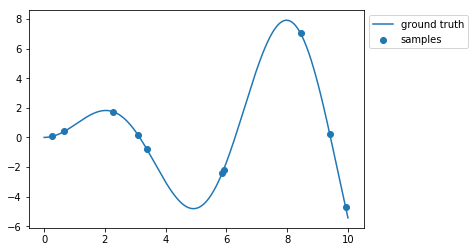

In [4]:
f = plt.plot(domain, func(domain), label="ground truth")
f = plt.scatter(x_sample, func(x_sample), label="samples")
f = plt.legend(loc="upper left", bbox_to_anchor=(1,1))

Obviously linear regression won't bring you far:

R2 = 0.006478280784242841


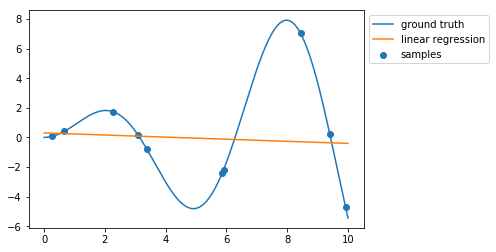

In [6]:
X = np.array([x_sample]).T
model = LinearRegression().fit(X, y_sample)
print("R2 =", model.score(X, y_sample))
f = plt.plot(domain, func(domain), label="ground truth")
f = plt.scatter(x_sample, func(x_sample), label="samples")
f = plt.plot([0, 10], [model.intercept_, model.intercept_ + 10 * model.coef_[0]], label="linear regression")
f = plt.legend(loc="upper left", bbox_to_anchor=(1,1))

Now try a few polynomial regressions to fit the given sample data points.

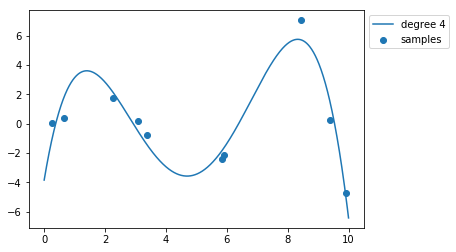

In [7]:
X = np.array([x_sample]).T
# f = plt.plot(x, func(x), label="ground truth", alpha=.4)
f = plt.scatter(x_sample, func(x_sample), label="samples")

degree = 4
model = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(X, y_sample)
y_pred = model.predict(np.array([domain]).T)
plt.plot(domain, y_pred, label="degree %d" % degree)

f = plt.legend(loc="upper left", bbox_to_anchor=(1,1))

- It's actually a result from algebra that you can fit *any* finite set of data points with a polynomial. 
- In fact, for any set of $n$ data points, there exists a polynomial of degree $n$ that goes right through them.
- This is great if you'd want to approximate your data arbitrarily closely.
- It's not great if you're afraid of overfitting your data

### Overfitting

Suppose you want to find a model behind some data, which also contains some arbitrary noise.

In [8]:
func = lambda x: 1 + .1 * (x - 4) ** 2 + 4 * np.random.random(len(x))

In [9]:
N, n = 1000, 30
domain = np.linspace(0, 15, N)
x_sample = np.linspace(0, 15, n)
y_sample = func(x_sample)

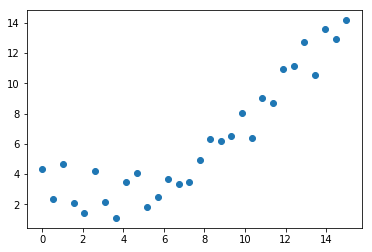

In [10]:
f = plt.scatter(x_sample, func(x_sample))

Obviously you could fit this noise by an arbitrarily complex model.

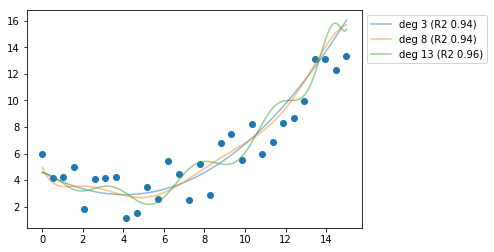

In [14]:
X = np.array([x_sample]).T
f = plt.scatter(x_sample, func(x_sample))

for degree in [3, 8, 13]:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(X, y_sample)
    y_pred = model.predict(np.array([domain]).T)
    plt.plot(domain, y_pred, alpha=.5, label="deg %d (R2 %.2f)" % (degree, model.score(X, y_sample)))

f = plt.legend(loc="upper left", bbox_to_anchor=(1,1))

It makes sense that that is obviously not what you want.

NameError: name 'xrange' is not defined

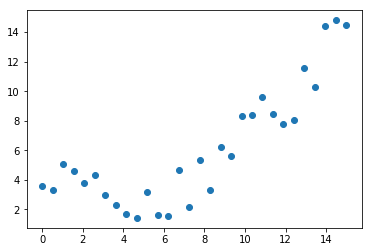

In [15]:
f = plt.scatter(x_sample, func(x_sample), label="samples")
for degree in [1, 2, 3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # Compute a few R2 scores and print average performance
    scores = []
    for k in xrange(15):
        X_train, X_test, y_train, y_test = train_test_split(X, y_sample, train_size=.7)
        scores.append(model.fit(X_train, y_train).score(X_test, y_test))
    print("For degree", degree, ", R2 =", np.mean(scores))
    # Take last model to plot predictions
    y_pred = model.predict(np.array([domain]).T)
    plt.plot(domain, y_pred, alpha=.5, label="deg %d (R2 %.2f)" % (degree, model.score(X_test, y_test)))

    f = plt.legend(loc="upper left", bbox_to_anchor=(1,1))

It seems that a second or third degree polynomial performs better than a fifth one on unseen data, which makes sense, since that's how we generated the samples.

Let's compare the different models once more:

In [ ]:
def analyze_performance(test_model):
    scores = {'overfit': {}, 'cv': {}}
    for degree in xrange(0, 30):
        model = make_pipeline(PolynomialFeatures(degree), test_model)    
        scores['overfit'][degree] = model.fit(X, y_sample).score(X, y_sample)
        cv_scores = []
        for k in xrange(15):  # Compute a few R2 scores and print average performance
            X_train, X_test, y_train, y_test = train_test_split(X, y_sample, train_size=.7)
            cv_scores.append(model.fit(X_train, y_train).score(X_test, y_test))
        scores['cv'][degree] = np.mean(cv_scores)
    return pd.DataFrame(scores)

In [ ]:
scores = analyze_performance(LinearRegression())
f = scores.plot(ylim=(-.05,1.05))
f = plt.title("Best cv performance at degree %d" % scores.cv.argmax()), plt.xlabel('degree'), plt.ylabel('$R^2$')

### Regularization

If your model is very complex (i.e., lots of features, possibly a polynomial fit, etc.), you need to worry more about overfitting.
- You'll need regularization when your model is complex, which happens when you have little data or many features.
- The example below uses the same dataset as above, but with fewer samples, and a relatively high degree model.
- We'll fit the (unregularized) `LinearRegression`, as well as the (regularized) `Ridge` and `Lasso` model.
  - Lasso regression imposes an L1 prior on the coefficient, causing many coeffiecients to be zero.
  - Ridge regression imposes an L2 prior on the coefficient, causing outliers to be less likely, and coeffiecients to be small across the board.

In [ ]:
x_small_sample = x_sample[::4]
y_small_sample = func(x_small_sample)

degree, alpha = 4, 10

X = np.array([x_small_sample]).T
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for no, my_model in enumerate([LinearRegression(), Ridge(alpha=alpha), Lasso(alpha=alpha)]):    
    model = make_pipeline(PolynomialFeatures(degree), my_model)    
    r2, MSE = [], []
    for k in xrange(100):  # Fit a few times the model to different training sets
        X_train, X_test, y_train, y_test = train_test_split(X, y_small_sample, train_size=.7)
        r2.append(model.fit(X_train, y_train).score(X_test, y_test))
        y_pred = model.predict(np.array([domain]).T)
        axes[no].plot(domain, y_pred, alpha=.3)
        y_pred_sample = model.predict(np.array([x_small_sample]).T)
        MSE.append(np.square(y_pred_sample - y_small_sample).sum())
    axes[no].scatter(x_small_sample, y_small_sample, s=70)
    axes[no].set_title("%s (R2 %.2f, MSE %3d)" % (my_model.__class__.__name__, np.mean(scores), np.mean(MSE)))
    axes[no].set_xlim(-.2, max(domain)), axes[no].set_ylim(-1, 21)

- Indeed, the unregularized `LinearRegression` leads to a model that is too complex and tries to fit the noise. 
- Note the differences in the (averaged) mean square error, or MSE, as well the complexity in the plots
- Note that the $R^2$ metric is not helpful here.

#### Increasing complexity

Let's try a few degrees with a regularized model.

In [ ]:
test_models = [LinearRegression(), Ridge(alpha=10), Lasso(alpha=10)]

scores = [analyze_performance(my_model) for my_model in test_models]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for no, score in enumerate(scores):
    s, name = pd.DataFrame(score), test_models[no].__class__.__name__
    f = s.plot(ylim=(-.05,1.05), ax=axes[no], legend=False)
    f = axes[no].set_title("%s\nBest cv performance at degree %d" % (name, s.cv.argmax()))
    f = axes[no].set_xlabel('degree'), axes[no].set_ylabel('$R^2$')

We could try a few different values for $\alpha$ as well.

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
for col, alpha in enumerate([0, 1, 10, 100]):
    scores = [analyze_performance(my_model) for my_model in [Ridge(alpha=alpha), Lasso(alpha=alpha)]]
    for row, score in enumerate(scores):
        s, name = pd.DataFrame(score), test_models[row].__class__.__name__
        f = s.plot(ylim=(-.05,1.05), ax=axes[row, col], legend=False)
        f = axes[row, col].set_title("%s (alpha %d)\nBest cv at degree %d" % (name, alpha, s.cv.argmax()))
        f = axes[row, col].set_xlabel('degree'), axes[row, col].set_ylabel('$R^2$')
f = plt.tight_layout()

We see that that Ridge and Lasso keep performing well for higher degrees, because of their regularization.



<hr>

## Exercises

(Not verified yet.)

Take a dataset from the previous Linear Regression notebook (eg Princeton salaries or Boston house prices) and try to repeat the exercises using regularization.


```Python
from sklearn import linear_model

model = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
model.fit(X,y)

print model.coef_
print model.alpha_
```

### Additional Resources
- [Linear Regression with Python](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)
- [Statsmodels Documentation](http://statsmodels.sourceforge.net/stable/index.html)
- [Python 538 Model](https://github.com/jseabold/538model)
